Sequencing protocols have two major variations (stranded, non-stranded). Stranded versions are needed for looking at things like annotation, while non-stranded protocols are acceptable for things like expression profiling. Their use may also vary based on the type of sequencing done (e.g., RNA-seq, ChIP-seq, DNA-seq) may have different proportions of studies that used stranded vs non-stranded.

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-09-26 
Git hash: 66f9f13d1f61c4b4c88c3e2cee03892c25fdd4d6


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']

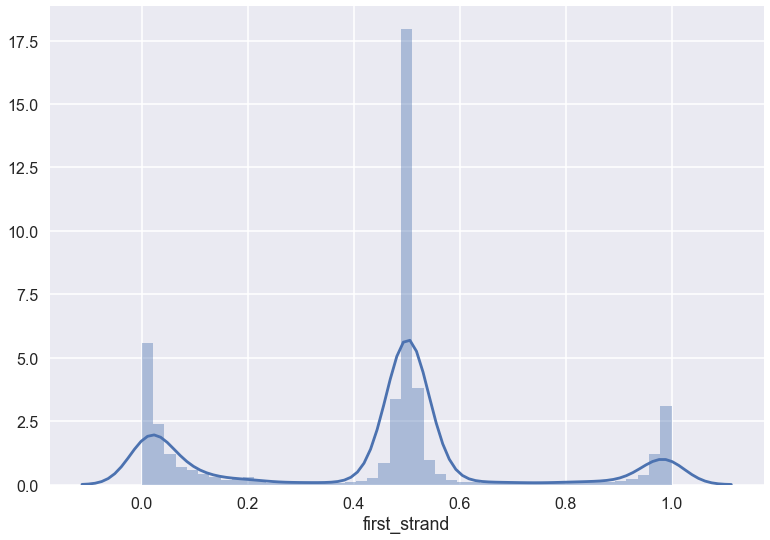

In [3]:
# Query DB and get strand information.

## Quick count for sanity
num_runs = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {'$count': 'cnt'}
]))[0]['cnt']

## Make strand dataframe
df = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'first_strand': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_CORRECT_STRAND_READS',
            'second_strand': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_CORRECT_STRAND_READS'
        }
    },
])))

# Sanity checks
num_srrs = df.shape[0]
num_srxs = df.srx.unique().size
assert num_srrs == num_runs

# Distribution plot
sns.distplot(df.first_strand)

In [4]:
# Create indicators based on proporiton of reads aligning to specific strand.
## 0 == unstranded
## 1 == moderate first stranded
## 2 == well first stranded
## -1 == moderate second stranded
## -2 == well second stranded

df['indicator_strand'] = 0
df.loc[df.first_strand >= .75, 'indicator_strand'] = 1
df.loc[df.first_strand >= .95, 'indicator_strand'] = 2
df.loc[df.second_strand >= .75, 'indicator_strand'] = -1
df.loc[df.second_strand >= .95, 'indicator_strand'] = -2

In [5]:
# Count the number of srrs per srx and check for consitent strandedness
def test_strand(x):
    return x.indicator_strand.replace(2, 1).replace(-2, -1).unique().size == 1

srx_counts = df[['srx', 'srr']].groupby('srx').count()
srx_tests = df[['srx', 'indicator_strand']].groupby('srx').agg(test_strand)
srx_tests.rename(columns={'indicator_strand': 'flag_strand_identical_among_srr'}, inplace=True)
srx = srx_counts.join(srx_tests)
srx.rename(columns={'srr': 'num_srr'}, inplace=True)

num_srx = '{:,}'.format(srx.shape[0])
num_srx_multi = '{:,}'.format(srx[srx.num_srr > 1].shape[0])
num_multi_srr_identical = '{:,}'.format(srx[(srx.num_srr >1) & srx.flag_strand_identical_among_srr].shape[0])
num_multi_srr_diff = '{:,}'.format(srx[(srx.num_srr >1) & ~srx.flag_strand_identical_among_srr].shape[0])

Of the {{num_srx}} SRXs, there are {{num_srx_multi}} SRXs that have multiple SRRs. The majority ({{num_multi_srr_identical}}) are classified as having the same strandedness, but there are {{num_multi_srr_diff}} that do not show consistent strandedness across SRRs.

In [6]:
# Sanity check the 40 that differ
diff = srx[(srx.num_srr >1) & ~srx.flag_strand_identical_among_srr].index
df[df.srx.isin(diff)].head(10)

,first_strand,second_strand,srr,srx,indicator_strand
968,0.326839,0.673161,ERR393593,ERX365267,0
969,0.353633,0.646367,ERR395048,ERX365267,0
970,0.185983,0.814017,ERR394451,ERX365267,-1
971,0.370150,0.629850,ERR393012,ERX365267,0
972,0.165767,0.834233,ERR393035,ERX365267,-1
991,0.401504,0.598496,ERR394739,ERX365170,0
992,0.402173,0.597827,ERR393838,ERX365170,0
993,0.311647,0.688353,ERR395084,ERX365170,0
994,0.211200,0.788800,ERR392700,ERX365170,-1
995,0.183073,0.816927,ERR393097,ERX365170,-1


In [7]:
# Merge everything together
df.merge(srx, left_on='srx', right_index=True, how='outer').set_index(['srx', 'srr'])

,,first_strand,second_strand,indicator_strand,num_srr,flag_strand_identical_among_srr
srx,srr,,,,,
SRX2581987,SRR5278103,0.523353,0.476647,0,1,True
SRX2556775,SRR5251041,0.988778,0.011222,2,1,True
SRX2556774,SRR5251040,0.985756,0.014244,2,1,True
SRX2556773,SRR5251039,0.984342,0.015658,2,1,True
SRX2556772,SRR5251038,0.983578,0.016422,2,1,True
SRX2556771,SRR5251037,0.987304,0.012696,2,1,True
SRX2556770,SRR5251036,0.987532,0.012468,2,1,True
SRX2541782,SRR5234256,0.044397,0.955603,-2,1,True
SRX2541781,SRR5234255,0.032448,0.967552,-2,1,True
